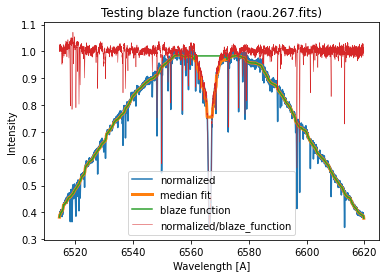

In [4]:
# MODIFIED FROM JACKIE TELSON's DEBLAZE FUNCTION 
# THIS IS NOT THE CURRENT DEBLAZING FUNCTION CALLED BY smemp_multifile.ipynb, SEE bstar_deblaze.ipynb

# deblaze_func.ipynb 
# Script to deblaze order 53 of APF spectra (not designed for other orders) using median filter to smooth and 
# masking out the H-Alpha features. 
# Written by Jackie Telson, last modified 8/12/20 by Anna Zuckerman 


import numpy as np
import astropy.io.fits as pf
#import matplotlib
from matplotlib import pyplot as plt
# ADZ: comment out imports below becuase unused
#import lmfit                          
#from lmfit import minimize, Parameters, report_fit, fit_report
#from IPython.display import Image
#import datascience as ds
#import scipy
from scipy import signal as sc
import os

# output: normalized, registered, and deblazed array
# must have 'apf_wav copy.fits' in directory
def normalized_registered_and_deblazed_array(file, order): # ADZ ADD 6/23/20 made input a file not a filename so  
                                                    # can be called from smemp_apf_test anf smemp_multifile. 
                                                    # Added input of which order to do
    #file = pf.open(file_name)                      # NOTE: also replaced all '53' below with 'order'
    header = file[0].header
    target_object = header['TOBJECT']
    #print(target_object) ADZ ADD 
    image = file[0].data
    
    wave = pf.open('apf_wav copy.fits')
    wave_values = wave[0].data
    
    x = wave_values[order,0:4600] 
    y = image[order,0:4600]
    
    # normalize y values to 1
    y_norm = y/np.percentile(np.sort(y),99)
    
    # debalze
    y_medfit = sc.medfilt(y_norm, kernel_size = 151)
    maximum = np.max(np.percentile(y_medfit, 96)) 
    fix = np.where(y_medfit[1750:2350]>0.97, y_medfit[1750:2350], maximum)

    new_y_medfit = np.append(y_medfit[:1750],fix)
    blaze_function = np.append(new_y_medfit, y_medfit[2350:])
    
    # register
    dl_l = (wave_values[order,2844:2845]-wave_values[order,2843:2844])/wave_values[order,2843:2844]  
    v = (dl_l*3*10**5)[0]
    lambda1 = wave_values[order,0]
    shifted = np.array([lambda1])
    for i in np.arange(0,4599):
        new_lambda = shifted[i] + (wave_values[order,i+1])*v/(3*10**5)
        shifted = np.append(shifted, new_lambda)
    
    print('Finished deblaze') #ADZ DELETE THIS
    return y_norm/blaze_function


# returns chi squared value between two H-alpha spectra
# 1st argument: file name of spectra you are testing (string) 
# 2nd argument: file name of know spectra (string) 

def chi_squared_value(test, known):
    test_array = normalized_registered_and_deblazed_array(test)
    known_array = normalized_registered_and_deblazed_array(known)
    return np.sum(((test_array - known_array)**2)/test_array)


# 1st argument: file name of spectra(string) 
# 2nd argument: name of directory with other star files (string) 

def best_chi_squared_value(target_object, directory_name):
    directory = os.fsencode(directory_name)
    cs_values = np.array([])

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.fits'):
            cs_value = np.array([chi_squared_value(target_object, filename), filename])
            cs_values = np.append(cs_values, cs_value)
    best_cs = np.sort(cs_values)[1]
    return best_cs
